In [7]:
from rdkit import Chem
from matplotlib import pyplot as plt
import networkx as nx
from IPython.display import display

## Loading a molecule from a SMILES string

### Load the SMILS and print the 2D chemical structure

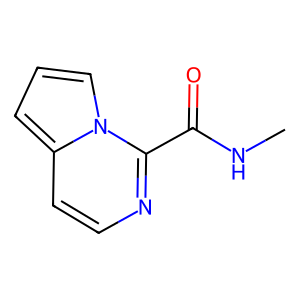

In [23]:
molecule = Chem.MolFromSmiles('CNC(=O)c1nccc2cccn12')
from rdkit.Chem import Draw
img = Draw.MolToImage(molecule)
display(img)

You can also show the chemical with the hydrogens attached as this isnt done by default.

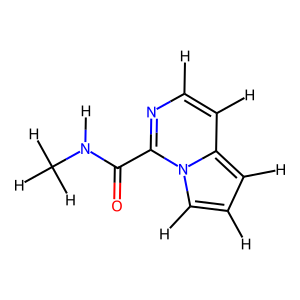

In [24]:
molecule_h = Chem.AddHs(molecule)
img_h = Draw.MolToImage(molecule_h)
display(img_h)

### Chemical Highlighting

Images of chemical structures with highlighted atoms can also be generated using the `Draw` module from RDKit.

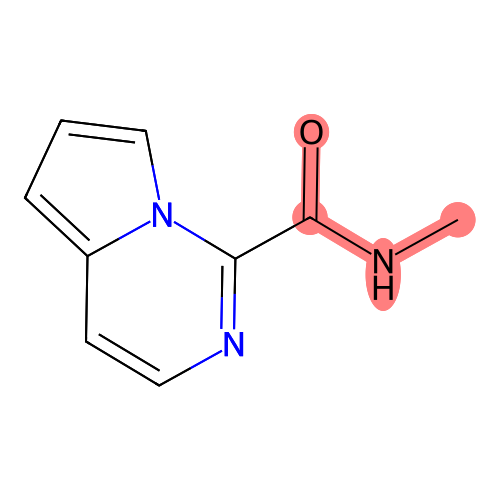

In [ ]:
from rdkit.Chem import rdMolDraw2D
rdMolDraw2D.PrepareAndDrawMolecule(d, molecule, highlightAtoms=hit_ats, highlightBonds=hit_bonds)
d.FinishDrawing()
SVG(d.GetDrawingText())



# Graphs and Geometry

### 2D depiction coordinates

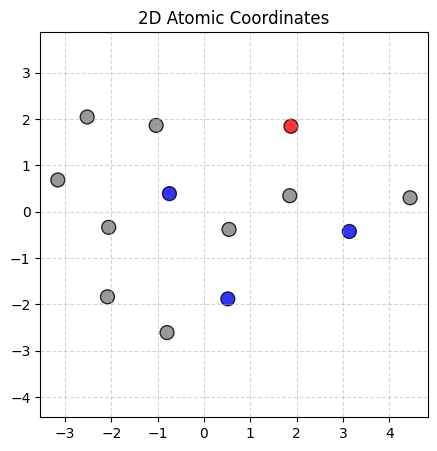

In [27]:
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

def generate_structure_depiction(mol, template_mol=None):
    """
    Generates 2D coordinates for a molecule, optionally matching a template structure.
    Returns the conformer coordinates.
    """
    # Compute 2D coordinates for the molecule
    AllChem.Compute2DCoords(mol)
    
    # If a template is provided, align the molecule to the template
    if template_mol is not None:
        AllChem.GenerateDepictionMatching2DStructure(mol, template_mol)
        
    # Extract coordinates
    conformer = mol.GetConformer()
    coords = conformer.GetPositions()
    return coords

coords = generate_structure_depiction(molecule)

# Define atom colors (CPK-like)
cpk_colors = {
    'C': 'gray',
    'O': 'red',
    'N': 'blue',
    'S': 'yellow',
    'P': 'orange',
    'F': 'green',
    'Cl': 'green',
    'Br': 'darkred',
    'I': 'purple',
    'H': 'lightgray'
}

# Get colors for each atom in the molecule
colors = [cpk_colors.get(atom.GetSymbol(), 'black') for atom in molecule.GetAtoms()]

# Visualize the atomic positions
plt.figure(figsize=(5, 5))
plt.scatter(coords[:, 0], coords[:, 1], s=100, c=colors, alpha=0.8, edgecolors='black')
plt.title("2D Atomic Coordinates")
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

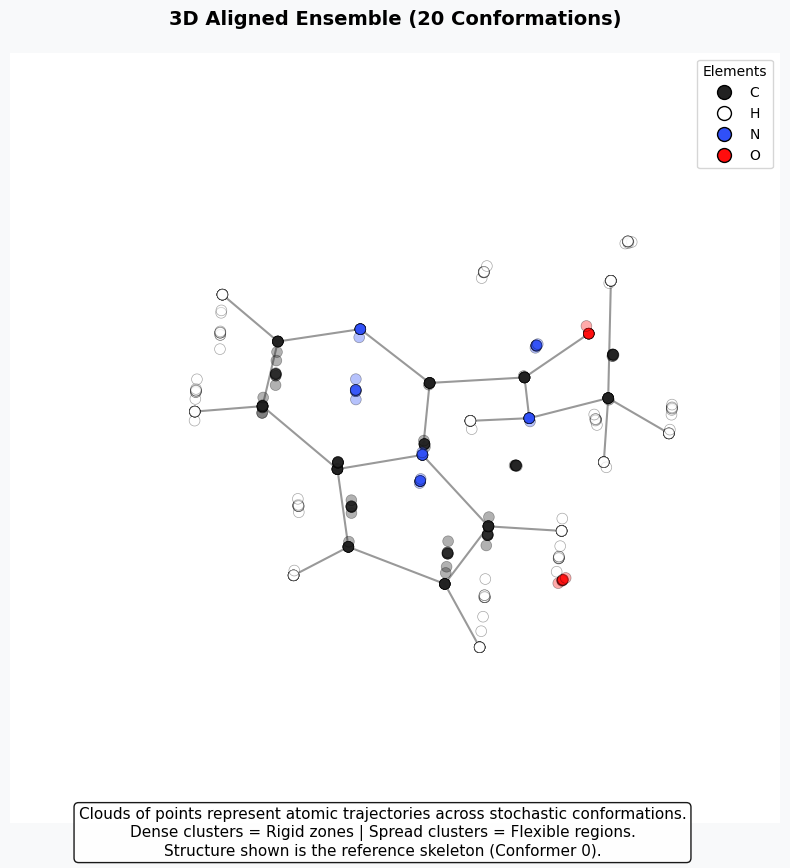

In [30]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolAlign
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Define the molecule
smiles = "CNC(=O)c1nccc2cccn12"
molecule = Chem.MolFromSmiles(smiles)

def generate_3d_ensemble(mol, num_confs=20, seed=42):
    """Generates an ensemble of 3D conformations and aligns them."""
    mH = Chem.AddHs(mol)
    params = AllChem.ETKDGv3()
    params.randomSeed = seed
    
    AllChem.EmbedMultipleConfs(mH, numConfs=num_confs, params=params)
    AllChem.MMFFOptimizeMoleculeConfs(mH)
    rdMolAlign.AlignMolConformers(mH)
    return mH

# Generate the aligned ensemble
molecule_3d = generate_3d_ensemble(molecule)

# Element-to-color mapping (Standard CPK colors)
cpk_colors = {
    'C': '#222222', 'O': '#FF0D0D', 'N': '#3050F8', 
    'H': '#FFFFFF', 'S': '#FFFF30', 'P': '#FF8000',
}

fig = plt.figure(figsize=(10, 10), facecolor='#f8f9fa')
ax = fig.add_subplot(111, projection='3d')

# 1. Plot the skeletal bonds for the reference conformer
conf0 = molecule_3d.GetConformer(0)
for bond in molecule_3d.GetBonds():
    idx1, idx2 = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    p1, p2 = conf0.GetAtomPosition(idx1), conf0.GetAtomPosition(idx2)
    ax.plot([p1.x, p2.x], [p1.y, p2.y], [p1.z, p2.z], 
            color='black', alpha=0.4, linewidth=1.5, zorder=1)

# 2. Plot Atomic clouds across the ensemble
atoms = molecule_3d.GetAtoms()
seen_symbols = set()
for i, atom in enumerate(atoms):
    symbol = atom.GetSymbol()
    color = cpk_colors.get(symbol, '#CCCCCC')
    
    # Collect positions for this specific atom across all conformers
    atom_coords = np.array([conf.GetAtomPosition(i) for conf in molecule_3d.GetConformers()])
    
    # Plot the cloud
    ax.scatter(atom_coords[:, 0], atom_coords[:, 1], atom_coords[:, 2], 
               alpha=0.35, c=color, edgecolors='black', s=60, 
               linewidth=0.5, zorder=2)
    seen_symbols.add(symbol)

# 3. Add a Custom Legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=s, 
                          markerfacecolor=cpk_colors.get(s, '#CCC'), 
                          markersize=10, markeredgecolor='k') for s in sorted(list(seen_symbols))]
ax.legend(handles=legend_elements, title="Elements", loc='upper right', frameon=True)

# 4. Final Polish
ax.set_title(f"3D Aligned Ensemble ({molecule_3d.GetNumConformers()} Conformations)", 
             fontsize=14, fontweight='bold', pad=20)
ax.view_init(elev=25, azim=35) # Better viewing angle
ax.set_axis_off() # Cleaner look without the box grid

explanation = (
    "Clouds of points represent atomic trajectories across stochastic conformations.\n"
    "Dense clusters = Rigid zones | Spread clusters = Flexible regions.\n"
    "Structure shown is the reference skeleton (Conformer 0)."
)
plt.figtext(0.5, 0.08, explanation, wrap=True, horizontalalignment='center', 
            fontsize=11, fontname='sans-serif', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.show()


## 3D Plotting

In [34]:
import py3Dmol
from rdkit import Chem

view = py3Dmol.view()
view.addModel(Chem.MolToMolBlock(molecule), 'mol')
view.setStyle({'stick': {}, 'sphere': {'scale': 0.3}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Graph Traversal

In [43]:
for i, atom in enumerate(molecule.GetAtoms()):
    print(i, atom.GetSymbol())

0 C
1 N
2 C
3 O
4 C
5 N
6 C
7 C
8 C
9 C
10 C
11 C
12 N


In [44]:
for bond in molecule.GetBonds():
    print(bond.GetBondType())

SINGLE
SINGLE
DOUBLE
SINGLE
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
